In [1]:
#Python-related imports
from datetime import datetime

#PyData imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function

In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)

#Module imports
from TruncatedNormal import *
from mean_field import *
from obs_and_flow import LowerBound

In [3]:
torch.manual_seed(0)
np.random.seed(0)
torch.set_printoptions(precision = 8)
device = torch.device('cpu')

In [4]:
batch_size = 10

temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

prior_scale_factor = 0.333

#Parameter prior means
u_M_mean = 0.0016
a_SD_mean = 0.5
a_DS_mean = 0.5
a_M_mean = 0.5
a_MSC_mean = 0.5
k_S_ref_mean = 0.0005
k_D_ref_mean = 0.0008
k_M_ref_mean = 0.0007
Ea_S_mean = 55
Ea_D_mean = 48
Ea_M_mean = 48
s_SOC_mean = 0.01
s_DOC_mean = 0.01
s_MBC_mean = 0.01

#SCON theta truncated normal distribution parameter details in order of mean, sdev, lower, and upper.
u_M_details = torch.Tensor([u_M_mean, u_M_mean * prior_scale_factor, 0, 1])
a_SD_details = torch.Tensor([a_SD_mean, a_SD_mean * prior_scale_factor, 0, 1])
a_DS_details = torch.Tensor([a_DS_mean, a_DS_mean * prior_scale_factor, 0, 1])
a_M_details = torch.Tensor([a_M_mean, a_M_mean * prior_scale_factor, 0, 1])
a_MSC_details = torch.Tensor([a_MSC_mean, a_MSC_mean * prior_scale_factor, 0, 1])
k_S_ref_details = torch.Tensor([k_S_ref_mean, k_S_ref_mean * prior_scale_factor, 0, 1])
k_D_ref_details = torch.Tensor([k_D_ref_mean, k_D_ref_mean * prior_scale_factor, 0, 1])
k_M_ref_details = torch.Tensor([k_M_ref_mean, k_M_ref_mean * prior_scale_factor, 0, 1])
Ea_S_details = torch.Tensor([Ea_S_mean, Ea_S_mean * prior_scale_factor, 10, 100])
Ea_D_details = torch.Tensor([Ea_D_mean, Ea_D_mean * prior_scale_factor, 10, 100])
Ea_M_details = torch.Tensor([Ea_M_mean, Ea_M_mean * prior_scale_factor, 10, 100])

#SCON-SS diffusion matrix parameter distribution details
s_SOC_details = torch.Tensor([s_SOC_mean, s_SOC_mean * prior_scale_factor, 0, 1])
s_DOC_details = torch.Tensor([s_DOC_mean, s_DOC_mean * prior_scale_factor, 0, 1])
s_MBC_details = torch.Tensor([s_MBC_mean, s_MBC_mean * prior_scale_factor, 0, 1])

##SCON-SS theta rsample draws
#u_M = TruncatedNormal(loc = u_M_details[0], scale = u_M_details[1], a = u_M_details[2], b = u_M_details[3]).rsample().cpu().detach().numpy()
#a_SD = TruncatedNormal(loc = a_SD_details[0], scale = a_SD_details[1], a = a_SD_details[2], b = a_SD_details[3]).rsample().cpu().detach().numpy()
#a_DS = TruncatedNormal(loc = a_DS_details[0], scale = a_DS_details[1], a = a_DS_details[2], b = a_DS_details[3]).rsample().cpu().detach().numpy()
#a_M = TruncatedNormal(loc = a_M_details[0], scale = a_M_details[1], a = a_M_details[2], b = a_M_details[3]).rsample().cpu().detach().numpy()
#a_MSC = TruncatedNormal(loc = a_MSC_details[0], scale = a_MSC_details[1], a = a_MSC_details[2], b = a_MSC_details[3]).rsample().cpu().detach().numpy()
#k_S_ref = TruncatedNormal(loc = k_S_ref_details[0], scale = k_S_ref_details[1], a = k_S_ref_details[2], b = k_S_ref_details[3]).rsample().cpu().detach().numpy()
#k_D_ref = TruncatedNormal(loc = k_D_ref_details[0], scale = k_D_ref_details[1], a = k_D_ref_details[2], b = k_D_ref_details[3]).rsample().cpu().detach().numpy()
#k_M_ref = TruncatedNormal(loc = k_M_ref_details[0], scale = k_M_ref_details[1], a = k_M_ref_details[2], b = k_M_ref_details[3]).rsample().cpu().detach().numpy()
#Ea_S = TruncatedNormal(loc = Ea_S_details[0], scale = Ea_S_details[1], a = Ea_S_details[2], b = Ea_S_details[3]).rsample().cpu().detach().numpy()
#Ea_D = TruncatedNormal(loc = Ea_D_details[0], scale = Ea_D_details[1], a = Ea_D_details[2], b = Ea_D_details[3]).rsample().cpu().detach().numpy()
#Ea_M = TruncatedNormal(loc = Ea_M_details[0], scale = Ea_M_details[1], a = Ea_M_details[2], b = Ea_M_details[3]).rsample().cpu().detach().numpy()
#s_SOC = TruncatedNormal(loc = s_SOC_details[0], scale = s_SOC_details[1], a = s_SOC_details[2], b = s_SOC_details[3]).rsample().cpu().detach().numpy()
#s_DOC = TruncatedNormal(loc = s_DOC_details[0], scale = s_DOC_details[1], a = s_DOC_details[2], b = s_DOC_details[3]).rsample().cpu().detach().numpy()
#s_MBC = TruncatedNormal(loc = s_MBC_details[0], scale = s_MBC_details[1], a = s_MBC_details[2], b = s_MBC_details[3]).rsample().cpu().detach().numpy()

SCON_SS_priors_details = {'u_M': u_M_details, 'a_SD': a_SD_details, 'a_DS': a_DS_details, 'a_M': a_M_details, 'a_MSC': a_MSC_details, 'k_S_ref': k_S_ref_details, 'k_D_ref': k_D_ref_details, 'k_M_ref': k_M_ref_details, 'Ea_S': Ea_S_details, 'Ea_D': Ea_D_details, 'Ea_M': Ea_M_details, 's_SOC': s_SOC_details, 's_DOC': s_DOC_details, 's_MBC': s_MBC_details}

In [5]:
priors = MeanField(device, list(SCON_SS_priors_details.keys()), SCON_SS_priors_details, TruncatedNormal, False)
params_dict, _, _, _ = priors(batch_size)

for k, v in params_dict.items():
    v = v.detach().cpu().numpy()
    params_dict[k] = v[:, np.newaxis]

In [6]:
def temp_func(t, TEMP_REF, TEMP_RISE):
    temp = TEMP_REF + (TEMP_RISE * t) / (80 * 24 * 365) + 10 * np.sin((2 * np.pi / 24) * t) + 10 * np.sin((2 * np.pi / (24 * 365)) * t)
    return temp

def I_S_func(t):
    return 0.001 + 0.0005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous SOC input function

def I_D_func(t):
    return 0.0001 + 0.00005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous DOC input function

def arrhenius_temp(parameter, temp, Ea, temp_ref):
    '''
    For a parameter with Arrhenius temperature dependence, returns the transformed parameter value.
    0.008314 is the gas constant. Temperatures are in K.
    '''
    decayed_parameter = parameter * np.exp(-Ea / 0.008314 * (1 / temp - 1 / temp_ref))
    return decayed_parameter

def linear_temp(parameter, temp, Q, temp_ref):
    '''
    For a parameter with linear temperature dependence, returns the transformed parameter value.
    Q is the slope of the temperature dependence and is a varying parameter.
    Temperatures are in K.
    '''
    modified_parameter = parameter - Q * (temp - temp_ref)
    return modified_parameter

In [7]:
transformed_temp = arrhenius_temp(params_dict['k_S_ref'], 300, params_dict['Ea_S'], temp_ref)
print(transformed_temp)

[[0.00199662]
 [0.00135829]
 [0.00105331]
 [0.00355522]
 [0.00306631]
 [0.00300804]
 [0.00216707]
 [0.00102003]
 [0.00239584]
 [0.00325786]]


In [8]:
params_dict['s_SOC'].shape[0]

10

In [9]:
#Generate data from SBM SDEs
#x in order of SOC, DOC, MBC (and EEC for AWB family models)

def alpha_SCON_multi(x, SCON_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Partition SOC, DOC, and MBC values.
    state_dim = 3
    SOC, DOC, MBC = np.array_split(x, state_dim, 1)
    #Force temperature-dependent parameters.
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], temp_ref)
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], temp_ref)
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], temp_ref)
    #Evolve drift.
    SOC = I_S + SCON_params_dict['a_DS'] * k_D * DOC + SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'] * k_M * MBC - k_S * SOC
    DOC = I_D + SCON_params_dict['a_SD'] * k_S * SOC + SCON_params_dict['a_M'] * (1 - SCON_params_dict['a_MSC']) * k_M * MBC - (SCON_params_dict['u_M'] + k_D) * DOC
    MBC = SCON_params_dict['u_M'] * DOC - k_M * MBC
    return np.concatenate([SOC, DOC, MBC], 1)

def beta_SCON_C_multi(x, SCON_C_params_dict):
    b11 = torch.Tensor(SCON_C_params_dict['c_SOC'])
    b22 = torch.Tensor(SCON_C_params_dict['c_DOC'])
    b33 = torch.Tensor(SCON_C_params_dict['c_MBC'])
    b_matrix = torch.diag_embed(torch.cat([b11, b22, b33], 1)) 
    return b_matrix.detach().numpy()

def beta_SCON_SS_multi(x, SCON_SS_params_dict):
    state_dim = 3
    SOC, DOC, MBC = np.array_split(x, state_dim, 1) #Partition SOC, DOC, and MBC values.
    b11 = torch.Tensor(SCON_SS_params_dict['s_SOC'] * SOC)
    b22 = torch.Tensor(SCON_SS_params_dict['s_DOC'] * DOC)
    b33 = torch.Tensor(SCON_SS_params_dict['s_MBC'] * MBC)
    b_matrix = torch.diag_embed(torch.cat([b11, b22, b33], 1)) 
    return b_matrix.detach().numpy()

def alpha_SAWB_multi(x, SAWB_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Partition SOC, DOC, MBC, and EEC values.
    state_dim = 4
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 1)
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], temp_ref)
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], temp_ref)
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_M'] * MBC - ((V_D * EEC * SOC) / (SAWB_params_dict['K_D'] + SOC))
    DOC = I_D + (1 - SAWB_params_dict['a_MSA']) * SAWB_params_dict['r_M'] * MBC + ((V_D * EEC * SOC) / (SAWB_params_dict['K_D'] + SOC)) + SAWB_params_dict['r_L'] * EEC - ((V_U * MBC * DOC) / (SAWB_params_dict['K_U'] + DOC))
    MBC = (u_Q * (V_U * MBC * DOC) / (SAWB_params_dict['K_U'] + DOC)) - (SAWB_params_dict['r_M'] + SAWB_params_dict['r_E']) * MBC
    EEC = SAWB_params_dict['r_E'] * MBC - SAWB_params_dict['r_L'] * EEC
    return np.concatenate([SOC, DOC, MBC, EEC], 1)

def beta_SAWB_C_multi(x, SAWB_C_params_dict):
    b11 = torch.Tensor(SAWB_C_params_dict['c_SOC'])
    b22 = torch.Tensor(SAWB_C_params_dict['c_DOC'])
    b33 = torch.Tensor(SAWB_C_params_dict['c_MBC'])
    b44 = torch.Tensor(SAWB_C_params_dict['c_EEC'])
    b_matrix = torch.diag_embed(torch.cat([b11, b22, b33, b44], 1)) 
    return b_matrix.detach().numpy()

def beta_SAWB_SS_multi(x, SAWB_SS_params_dict):
    state_dim = 4
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 1) #Partition SOC, DOC, MBC, and EEC values.
    b11 = torch.Tensor(SAWB_SS_params_dict['s_SOC'] * SOC)
    b22 = torch.Tensor(SAWB_SS_params_dict['s_DOC'] * DOC)
    b33 = torch.Tensor(SAWB_SS_params_dict['s_MBC'] * MBC)
    b44 = torch.Tensor(SAWB_SS_params_dict['s_EEC'] * EEC)
    b_matrix = torch.diag_embed(torch.cat([b11, b22, b33, b44], 1)) 
    return b_matrix.detach().numpy()

def alpha_SAWB_ECA_multi(x, SAWB_ECA_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Partition SOC, DOC, MBC, and EEC values.
    state_dim = 4
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 1)
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], temp_ref)
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], temp_ref)
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['r_M'] * MBC - ((V_DE * EEC * SOC) / (SAWB_ECA_params_dict['K_DE'] + EEC + SOC))
    DOC = I_D + (1 - SAWB_ECA_params_dict['a_MSA']) * SAWB_ECA_params_dict['r_M'] * MBC + ((V_DE * EEC * SOC) / (SAWB_ECA_params_dict['K_DE'] + EEC + SOC)) + SAWB_ECA_params_dict['r_L'] * EEC - ((V_UE * MBC * DOC) / (SAWB_ECA_params_dict['K_UE'] + MBC + DOC))
    MBC = (u_Q * (V_UE * MBC * DOC) / (SAWB_ECA_params_dict['K_UE'] + MBC + DOC)) - (SAWB_ECA_params_dict['r_M'] + SAWB_ECA_params_dict['r_E']) * MBC
    EEC = SAWB_ECA_params_dict['r_E'] * MBC - SAWB_ECA_params_dict['r_L'] * EEC
    return np.concatenate([SOC, DOC, MBC, EEC], 1)

def beta_SAWB_ECA_C_multi(x, SAWB_ECA_C_params_dict):
    b11 = torch.Tensor(SAWB_ECA_C_params_dict['c_SOC'])
    b22 = torch.Tensor(SAWB_ECA_C_params_dict['c_DOC'])
    b33 = torch.Tensor(SAWB_ECA_C_params_dict['c_MBC'])
    b44 = torch.Tensor(SAWB_ECA_C_params_dict['c_EEC'])
    b_matrix = torch.diag_embed(torch.cat([b11, b22, b33, b44], 1)) 
    return b_matrix.detach().numpy()

def beta_SAWB_ECA_SS_multi(x, SAWB_ECA_SS_params_dict):
    state_dim = 4
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 1) #Partition SOC, DOC, MBC, and EEC values.
    b11 = torch.Tensor(SAWB_ECA_SS_params_dict['s_SOC'] * SOC)
    b22 = torch.Tensor(SAWB_ECA_SS_params_dict['s_DOC'] * DOC)
    b33 = torch.Tensor(SAWB_ECA_SS_params_dict['s_MBC'] * MBC)
    b44 = torch.Tensor(SAWB_ECA_SS_params_dict['s_EEC'] * EEC)
    b_matrix = torch.diag_embed(torch.cat([b11, b22, b33, b44], 1)) 
    return b_matrix.detach().numpy()

In [10]:
print(torch.Tensor(params_dict['s_SOC']))
print(torch.Tensor(params_dict['s_SOC']).size())
b11 = torch.Tensor(params_dict['s_SOC'])
b22 = torch.Tensor(params_dict['s_DOC'])
b33 = torch.Tensor(params_dict['s_MBC'])

print(torch.cat([b11, b22, b33], 1))

b_test = torch.diag_embed(torch.cat([b11, b22, b33], 1))
b_test_n = b_test.detach().numpy()
print(b_test_n)
print(b_test_n.shape)

tensor([[0.00917803],
        [0.01044795],
        [0.01216993],
        [0.01057143],
        [0.01098551],
        [0.01530174],
        [0.00691040],
        [0.01063521],
        [0.01211109],
        [0.00964534]])
torch.Size([10, 1])
tensor([[0.00917803, 0.00339356, 0.00682223],
        [0.01044795, 0.01556990, 0.00406915],
        [0.01216993, 0.01022495, 0.00769777],
        [0.01057143, 0.01325002, 0.00727585],
        [0.01098551, 0.01292882, 0.01684750],
        [0.01530174, 0.01391837, 0.00068273],
        [0.00691040, 0.01224597, 0.01088836],
        [0.01063521, 0.00821702, 0.01276661],
        [0.01211109, 0.00327298, 0.00725305],
        [0.00964534, 0.01085851, 0.01302493]])
[[[0.00917803 0.         0.        ]
  [0.         0.00339356 0.        ]
  [0.         0.         0.00682223]]

 [[0.01044795 0.         0.        ]
  [0.         0.0155699  0.        ]
  [0.         0.         0.00406915]]

 [[0.01216993 0.         0.        ]
  [0.         0.01022495 0.        

In [11]:
t = 100
dt = 0.1
n = int(t / dt) + 1

x_test = np.zeros([batch_size, n, 3])
print(x_test.shape)

(10, 1001, 3)


In [12]:
X0_test = np.array([65, 0.4, 2.5])
X0_test_samples = np.random.normal(loc = X0_test, scale = 0.25 * X0_test, size = np.array([batch_size, 3]))
print(X0_test_samples)
X0_test_samples.shape

[[ 93.66585062   0.44001572   3.11171124]
 [101.41451449   0.5867558    1.88920133]
 [ 80.43893678   0.38486428   2.43548822]
 [ 71.67222566   0.41440436   3.40892094]
 [ 77.36686303   0.4121675    2.77741452]
 [ 70.42220782   0.54940791   2.37177609]
 [ 70.08735015   0.31459043   0.90438137]
 [ 75.62130218   0.48644362   2.03614686]
 [101.88351264   0.25456343   2.52859907]
 [ 61.95826244   0.55327792   3.41834923]]


(10, 3)

In [13]:
x_test[:, 0, :] = X0_test_samples
print(x_test[:, 0, :])
print(x_test[:, 0, :].shape)
x0 = x_test[:, 0, :]
print(x0[:, 0])
print(x0[:, 1])
print(x0[:, 2])
print(x0[:, 0].shape)

x0_stack = np.stack((x0[:, 0], x0[:, 1], x0[:, 2]), 1)
print(x0_stack.shape)

x0_cat = np.concatenate((np.expand_dims(x0[:, 0], axis = 1), np.expand_dims(x0[:, 1], axis = 1), np.expand_dims(x0[:, 2], axis = 1)), 1)
print(x0_cat.shape)

[[ 93.66585062   0.44001572   3.11171124]
 [101.41451449   0.5867558    1.88920133]
 [ 80.43893678   0.38486428   2.43548822]
 [ 71.67222566   0.41440436   3.40892094]
 [ 77.36686303   0.4121675    2.77741452]
 [ 70.42220782   0.54940791   2.37177609]
 [ 70.08735015   0.31459043   0.90438137]
 [ 75.62130218   0.48644362   2.03614686]
 [101.88351264   0.25456343   2.52859907]
 [ 61.95826244   0.55327792   3.41834923]]
(10, 3)
[ 93.66585062 101.41451449  80.43893678  71.67222566  77.36686303
  70.42220782  70.08735015  75.62130218 101.88351264  61.95826244]
[0.44001572 0.5867558  0.38486428 0.41440436 0.4121675  0.54940791
 0.31459043 0.48644362 0.25456343 0.55327792]
[3.11171124 1.88920133 2.43548822 3.40892094 2.77741452 2.37177609
 0.90438137 2.03614686 2.52859907 3.41834923]
(10,)
(10, 3)
(10, 3)


In [14]:
print(x_test[:, 1, :].shape)
SOC, DOC, MBC = np.array_split(x0, 3, 1)
print(SOC)
print(SOC.shape)

(10, 3)
[[ 93.66585062]
 [101.41451449]
 [ 80.43893678]
 [ 71.67222566]
 [ 77.36686303]
 [ 70.42220782]
 [ 70.08735015]
 [ 75.62130218]
 [101.88351264]
 [ 61.95826244]]
(10, 1)


In [15]:
def get_CO2_CON_gen_y_multi(x, SCON_params_dict, current_temp, TEMP_REF):
    state_dim = 3 #SCON has three state variables in SOC, DOC, and MBC.
    SOC, DOC, MBC =  np.array_split(x, state_dim, 1) #Partition SOC, DOC, and MBC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor.
    #Decay parameters are forced by temperature changes.    
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_S_ref.
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_D_ref.
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_M_ref.
    CO2 = (k_S * SOC * (1 - SCON_params_dict['a_SD'])) + (k_D * DOC * (1 - SCON_params_dict['a_DS'])) + (k_M * MBC * (1 - SCON_params_dict['a_M']))
    return np.amax(CO2, 0)

def get_CO2_AWB_gen_y_multi(x, SAWB_params_dict, current_temp, TEMP_REF):
    state_dim = 4 #SAWB and SAWB-ECA have four state variables in SOC, DOC, MBC, and EEC.
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 1) #Partition SOC, DOC, MBC, EEC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor. 
    #Decay parameters are forced by temperature changes.    
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], TEMP_REF) #Apply linear temperature-dependence to u_Q.
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_D.
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_U.
    CO2 = (1 - u_Q) * (V_U * MBC * DOC) / (SAWB_params_dict['K_U'] + MBC + DOC)
    return np.amax(CO2, 0)

def get_CO2_AWB_ECA_gen_y_multi(x, SAWB_ECA_params_dict, current_temp, TEMP_REF):
    state_dim = 4 #SAWB and SAWB-ECA have four state variables in SOC, DOC, MBC, and EEC.
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 1) #Partition SOC, DOC, MBC, EEC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor. 
    #Decay parameters are forced by temperature changes.    
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], TEMP_REF) #Apply linear temperature-dependence to u_Q.
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_DE.
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_UE.
    CO2 = (1 - u_Q) * (V_UE * MBC * DOC) / (SAWB_ECA_params_dict['K_UE'] + MBC + DOC)
    return np.amax(CO2, 0)

In [16]:
params_dict['a_SD'].shape

(10, 1)

In [17]:
CO2_test = np.zeros([batch_size, n, 1])
print(CO2_test.shape)
CO2_test[:, 0, :] = get_CO2_CON_gen_y_multi(x_test[:, 0, :], params_dict, temp_func(0, temp_ref, temp_rise), temp_ref)

(10, 1001, 1)


In [18]:
I_S = I_S_func(0)
I_D = I_D_func(0)
print(x_test[:, 1, :].shape)
blah = alpha_SCON_multi(x_test[:, 0, :], params_dict, I_S, I_D, temp_func(0.1, temp_ref, temp_rise), temp_ref, arrhenius_temp, linear_temp)
print(blah.shape)
x_test[:, 1, :] = alpha_SCON_multi(x_test[:, 0, :], params_dict, I_S, I_D, temp_func(0.1, temp_ref, temp_rise), temp_ref, arrhenius_temp, linear_temp)
print(x_test[:, 1, :])
print(x_test[:, 1, 0])

(10, 3)
(10, 3)
[[-5.17871252e-02 -3.99458406e-04 -3.14608277e-03]
 [-4.00996660e-02 -4.02738208e-04 -1.96254647e-03]
 [-3.12973386e-02 -2.16244598e-04 -6.76657856e-04]
 [-4.52160633e-02 -5.69012881e-04 -2.40548783e-03]
 [-4.51429400e-02 -5.19485238e-04 -2.23993546e-03]
 [-5.30451454e-02 -7.78004075e-04 -8.36918006e-04]
 [-2.48591144e-02 -6.15997242e-04 -7.82366041e-04]
 [-3.27603761e-02  6.52333459e-05 -1.44184097e-03]
 [-5.18779396e-02 -1.42955531e-04 -1.97809463e-03]
 [-3.33588176e-02 -6.48014619e-04 -2.38927816e-03]]
[-0.05178713 -0.04009967 -0.03129734 -0.04521606 -0.04514294 -0.05304515
 -0.02485911 -0.03276038 -0.05187794 -0.03335882]


In [19]:
a = np.random.rand(batch_size, 3)
b = np.random.rand(batch_size, 3, 3)
c = np.zeros([batch_size, 3])

#loop
for i in range(batch_size):
    c[i, :] = np.random.multivariate_normal(mean = a[i, :], cov = b[i, :, :])

print(c)
print(c.shape)

a_melt = a.ravel()
print(a_melt.shape)

b_melt = b.ravel()
print(b_melt.shape)

b_reshape = b.reshape([30, 3])
print(b_reshape.shape)

c = np.random.multivariate_normal(mean = a_melt, cov = b_reshape)

x_test_2 = x_test
x_test_2[:, 1, :] = c[1, :]

<ipython-input-19-ca386be36590>:7: RuntimeWarning: covariance is not positive-semidefinite.
  c[i, :] = np.random.multivariate_normal(mean = a[i, :], cov = b[i, :, :])


[[ 1.3337915   1.11126724  1.129888  ]
 [-0.68504551 -0.81196937 -0.52523863]
 [ 0.99544375  1.35662354  0.95617612]
 [ 0.07483768  0.89183041 -0.01278106]
 [ 0.39257982 -0.09605476  0.43132395]
 [ 1.5841441   0.33151158  1.24753658]
 [ 1.17745941 -0.55126552 -0.20450993]
 [-0.47641658 -0.1472786  -0.9175795 ]
 [ 1.38475206  1.49162679  1.29791848]
 [-1.59262226  0.37584274 -1.24270779]]
(10, 3)
(30,)
(90,)
(30, 3)


ValueError: cov must be 2 dimensional and square

In [20]:
blah2 = beta_SCON_SS_multi(x_test[:, 0, :], params_dict)
print(blah2)

[[[8.5966808e-01 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 1.4932217e-03 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 2.1228824e-02]]

 [[1.0595742e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 9.1357278e-03 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 7.6874415e-03]]

 [[9.7893649e-01 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 3.9352174e-03 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 1.8747820e-02]]

 [[7.5767803e-01 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 5.4908656e-03 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 2.4802802e-02]]

 [[8.4991461e-01 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 5.3288401e-03 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 4.6792492e-02]]

 [[1.0775825e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 7.6468620e-03 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 1.6192722e-03]]

 [[4.8433146e-01 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 3.8524640e-03 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 9.8472331e-03]]

 [[8.0424821e-01 0.0

In [21]:
def get_SBM_SDE_euler_maruyama_y_multi(BATCH_SIZE, ALPHA, BETA, X0, X0_SCALE, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, TEMP_REF, TEMP_RISE, OBS_EVERY, OBS_ERROR_SCALE, lower_bound = 1e-4):
    state_dim = 0
    get_CO2_gen_y = None
    if ALPHA == alpha_SCON_multi:
        state_dim = 3
        get_CO2_gen_y = get_CO2_CON_gen_y_multi
    elif ALPHA == alpha_SAWB_multi:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_gen_y_multi
    elif ALPHA == alpha_SAWB_ECA_multi:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_ECA_gen_y_multi
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([BATCH_SIZE, N, state_dim])
    CO2 = np.zeros([BATCH_SIZE, N, 1])
    X0_array = np.array(X0)
    X0_samples = np.random.normal(loc = X0_array, scale = X0_SCALE * X0_array, size = np.array([BATCH_SIZE, state_dim])) #Add noise to initial conditions of x.
    X0_samples[X0_samples < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_samples = ', X0_samples)
    x[:, 0, :] = X0_samples
    CO2[:, 0, :] = get_CO2_gen_y(x[:, 0, :], THETA_DICT, TEMP_FUNC(0, TEMP_REF, TEMP_RISE), TEMP_REF)
    hour = 0
    for i in range(1, N):
        hour += DT
        I_S = I_S_FUNC(hour)
        I_D = I_D_FUNC(hour)
        current_temp = TEMP_FUNC(hour, TEMP_REF, TEMP_RISE)
        #Take Euler-Maruyama step. Note: np.random.normal takes std while np.random.multivariate_normal takes cov.
        a = ALPHA(x[:, i - 1, :], THETA_DICT, I_S, I_D, current_temp, TEMP_REF, arrhenius_temp, linear_temp)
        b = BETA(x[:, i - 1, :], THETA_DICT)
        for batch in range(batch_size):
            x[batch, i, :] = np.random.multivariate_normal(mean = x[batch, i - 1, :] + a[batch, :] * DT, cov = b[batch, :, :] * DT)
        x[:, i, :][x[:, i, :] < lower_bound] = lower_bound #Bound all x above 0.
        CO2[:, i, :] = get_CO2_gen_y(x[:, i, :], THETA_DICT, current_temp, TEMP_REF) #Compute CO2.
    x_with_CO2 = np.concatenate((x, CO2), 2)
    x_with_CO2_for_y = x_with_CO2[:, 0::int(OBS_EVERY / DT), :] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_with_CO2_for_y.mean(1)
    y = x_with_CO2_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_with_CO2_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_var_scale, 'x': x_with_CO2, 't_x': np.arange(0, T + DT, DT)}

def get_SBM_SDE_euler_maruyama_y_det(BATCH_SIZE, ALPHA, X0, X0_SCALE, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, TEMP_REF, TEMP_RISE, OBS_EVERY, OBS_ERROR_SCALE, lower_bound = 1e-4):
    state_dim = 0
    get_CO2_gen_y = None
    if ALPHA == alpha_SCON_multi:
        state_dim = 3
        get_CO2_gen_y = get_CO2_CON_gen_y_multi
    elif ALPHA == alpha_SAWB_multi:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_gen_y_multi
    elif ALPHA == alpha_SAWB_ECA_multi:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_ECA_gen_y_multi
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([BATCH_SIZE, N, state_dim])
    CO2 = np.zeros([BATCH_SIZE, N, 1])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0, :] = X0_sample
    CO2[:, 0, :] = get_CO2_gen_y(x[:, 0, :], THETA_DICT, TEMP_FUNC(0, TEMP_REF, TEMP_RISE), TEMP_REF) #Compute initial CO2.
    hour = 0
    for i in range(1, N):
        hour += DT
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, TEMP_REF, TEMP_RISE)
        #print('current_temp', current_temp)
        #Take Euler step.
        x[:, i, :] = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, TEMP_REF, arrhenius_temp, linear_temp) * DT
        x[:, i, :][x[:, i, :] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
        CO2[:, i, :] = get_CO2_gen_y(x[:, i, :], THETA_DICT, current_temp, TEMP_REF) #Compute CO2.
    x_with_CO2 = np.concatenate((x, CO2), 2)
    x_with_CO2_for_y = x_with_CO2[:, 0::int(OBS_EVERY / DT), :] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_with_CO2_for_y.mean(1)
    y = x_with_CO2_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_with_CO2_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_var_scale, 'x': x_with_CO2, 't_x': np.arange(0, T + DT, DT)}

In [22]:
dt = 0.01
t = 100
x0_SCON = [65, 0.4, 2.5]
obs_every = 5
obs_error_scale = 0.1
x0_scale = 0.25

In [23]:
y_dict = get_SBM_SDE_euler_maruyama_y_multi(batch_size, alpha_SCON_multi, beta_SCON_SS_multi, x0_SCON, x0_scale, t, dt, params_dict, I_S_func, I_D_func, temp_func, temp_ref, temp_rise, obs_every, obs_error_scale)

print('y: ', y_dict['y'])
print('x: ', y_dict['x'])

X0_samples =  [[63.40014648  0.33365217  3.20414745]
 [47.45111299  0.28525313  2.22636247]
 [56.90697268  0.59295321  3.093388  ]
 [66.42270767  0.27745645  3.02772686]
 [48.7465006   0.24552289  3.24251862]
 [70.15031744  0.49208588  2.69920478]
 [78.92349744  0.33489744  1.85359822]
 [76.07591092  0.31965903  2.06903139]
 [57.59759682  0.40174792  2.27875381]
 [42.65704148  0.33563816  1.11037303]]
y:  [[[5.83668166e+01 3.40139995e-01 3.30572060e+00 3.73297659e-02]
  [6.54080694e+01 2.51325338e-01 2.62302413e+00 8.93341816e-02]
  [5.44707890e+01 3.04512721e-01 2.66899235e+00 5.56587556e-02]
  [6.93767730e+01 1.75780416e-01 4.38941604e+00 1.87207563e-02]
  [5.94028327e+01 1.26567260e-01 3.51524356e+00 9.52091173e-03]
  [5.79733071e+01 1.41934699e-01 3.52474847e+00 4.80201395e-02]
  [5.48017734e+01 2.31680728e-01 2.69823331e+00 1.03083784e-01]
  [5.46674280e+01 1.87340544e-01 3.11701945e+00 5.19757579e-02]
  [5.23647632e+01 1.92894629e-01 2.50302140e+00 2.15548646e-02]
  [6.55305696e+

In [36]:
print('y shape: ', y_dict['y'].shape)
print('t_y shape: ', y_dict['t_y'].shape)
print('x shape: ', y_dict['x'].shape)

y shape:  (10, 21, 4)
t_y shape:  (21,)
x shape:  (10, 10001, 4)


In [35]:
print(y_dict['x'][:, :, 0].shape)
print(y_dict['x'][:, :, 0].transpose().shape)
print(y_dict['y'][:, :, 0].shape)
print(y_dict['y'][:, :, 0].transpose().shape)

(10, 10001)
(10001, 10)
(10, 21)
(21, 10)


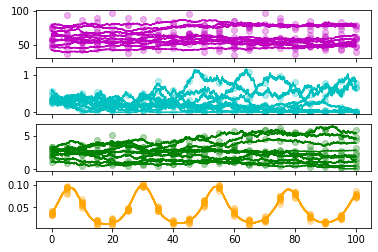

In [39]:
fig, axs = plt.subplots(4, sharex = True)
axs[0].plot(y_dict['t_x'], y_dict['x'][:, :, 0].transpose(), color = "m", label = 'SOC x')
axs[0].scatter(np.repeat(y_dict['t_y'][:, None], batch_size, axis = 1), y_dict['y'][:, :, 0].transpose(), color = "m", alpha = 0.3, label = 'SOC y')
axs[1].plot(y_dict['t_x'], y_dict['x'][:, :, 1].transpose(), color = "c", label = 'DOC x')
axs[1].scatter(np.repeat(y_dict['t_y'][:, None], batch_size, axis = 1), y_dict['y'][:, :, 1].transpose(), color = "c", alpha = 0.3, label = 'DOC y')
axs[2].plot(y_dict['t_x'], y_dict['x'][:, :, 2].transpose(), color = "g", label = 'MBC x')
axs[2].scatter(np.repeat(y_dict['t_y'][:, None], batch_size, axis = 1), y_dict['y'][:, :, 2].transpose(), color = "g", alpha = 0.3, label = 'MBC y')
axs[3].plot(y_dict['t_x'], y_dict['x'][:, :, 3].transpose(), color = "orange", label = 'CO2')
axs[3].scatter(np.repeat(y_dict['t_y'][:, None], batch_size, axis = 1), y_dict['y'][:, :, 3].transpose(), color = "orange", alpha = 0.3, label = 'CO2 y')

In [ ]:
now = datetime.now()
sbm_model = 'SCON-SS_CO2_trunc' + now.strftime('_%Y_%m_%d_%H_%M')
dir_path = '../generated_data/'
save_string = dir_path + f'{sbm_model}_sample_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
save_string_x = dir_path + f'{sbm_model}_sample_x_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
fig.savefig(save_string + '.png', dpi = 300)

In [ ]:
#Save CSV of stochastic path.
df_y = pd.DataFrame(data = {'hour': y_dict['t_y'], 'SOC': y_dict['y'][0, :], 'DOC': y_dict['y'][1, :], 'MBC': y_dict['y'][2, :], 'CO2': y_dict['y'][3, :]})
df_y.to_csv(save_string + '.csv', index = False)

In [ ]:
#Save rsampled theta values.
torch.save(SCON_SS_params_dict, save_string + '_rsample.pt')

#Save priors dict.
torch.save(SCON_SS_priors_dict, save_string + '_hyperparams.pt')

In [ ]:
print(df_y)

In [26]:
y_det_dict = get_SBM_SDE_euler_maruyama_y_det(batch_size, alpha_SCON_multi, x0_SCON, x0_scale, t, dt, params_dict, I_S_func, I_D_func, temp_func, temp_ref, temp_rise, obs_every, obs_error_scale)

print('y: ', y_det_dict['y'])
print('x: ', y_det_dict['x'])

X0_sample =  [69.62295581  0.41321962  2.4568312 ]
y:  [[[6.90300017e+01 3.62674175e-01 2.47618223e+00 4.00701400e-02]
  [6.28083174e+01 4.32122592e-01 2.58203118e+00 1.03850355e-01]
  [7.43925961e+01 4.21357038e-01 2.00000321e+00 5.61077768e-02]
  [6.96456477e+01 4.26660373e-01 2.53682740e+00 2.11929661e-02]
  [6.03624618e+01 3.38454195e-01 2.36435342e+00 1.10702923e-02]
  [6.18544096e+01 3.79225055e-01 2.08485557e+00 4.38451088e-02]
  [7.01297675e+01 4.13044026e-01 2.01205668e+00 1.06018260e-01]
  [7.37627120e+01 3.54362130e-01 2.01885703e+00 4.83373999e-02]
  [7.15261390e+01 3.45175078e-01 2.64351338e+00 1.15116313e-02]
  [7.45752504e+01 3.50710431e-01 2.57402241e+00 2.35858804e-02]
  [7.23593419e+01 3.71703773e-01 2.29230765e+00 6.38708223e-02]
  [6.22863692e+01 4.59157913e-01 2.10701692e+00 1.03999995e-01]
  [6.79735947e+01 3.18953444e-01 2.17100265e+00 3.26944653e-02]
  [6.79236913e+01 3.59595433e-01 2.36470897e+00 1.26333386e-02]
  [7.77060722e+01 3.50407732e-01 1.97600672e+00 1

In [ ]:
fig2, axs2 = plt.subplots(4, sharex = True)
axs2[0].plot(y_det_dict['t_x'], y_det_dict['x'][0, :], color = "m", label = 'SOC x')
axs2[0].scatter(y_det_dict['t_y'], y_det_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs2[1].plot(y_det_dict['t_x'], y_det_dict['x'][1, :], color = "c", label = 'DOC x')
axs2[1].scatter(y_det_dict['t_y'], y_det_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs2[2].plot(y_det_dict['t_x'], y_det_dict['x'][2, :], color = "g", label = 'MBC x')
axs2[2].scatter(y_det_dict['t_y'], y_det_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')
axs2[3].plot(y_det_dict['t_x'], y_det_dict['x'][3, :], color = "orange", label = 'CO2')
axs2[3].scatter(y_det_dict['t_y'], y_det_dict['y'][3, :], color = "orange", alpha = 0.3, label = 'CO2 y')

In [ ]:
save_string_det = dir_path + f'{sbm_model}_sample_det_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
fig2.savefig(save_string_det + '.png', dpi = 300)

In [ ]:
df_y_det = pd.DataFrame(data = {'hour': y_det_dict['t_y'], 'SOC': y_det_dict['y'][0, :], 'DOC': y_det_dict['y'][1, :], 'MBC': y_det_dict['y'][2, :], 'CO2': y_det_dict['y'][3, :]})
df_y_det.to_csv(save_string_det + '.csv', index = False)

In [ ]:
print(df_y_det)